In [122]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [123]:
train_img_path = 'Face Mask Dataset/Train'
test_img_path = 'Face Mask Dataset/Test'
validation_img_path = 'Face Mask Dataset/Validation'

In [124]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest',
    validation_split=0.2,
)

In [125]:
train_generator = train_datagen.flow_from_directory(
    train_img_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    subset='training',
)

validation_generator = train_datagen.flow_from_directory(
    validation_img_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    subset='validation',
)

test_generator = train_datagen.flow_from_directory(
    test_img_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
)

Found 8000 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [126]:
class_names = list(train_generator.class_indices.keys())
class_names

['WithMask', 'WithoutMask']

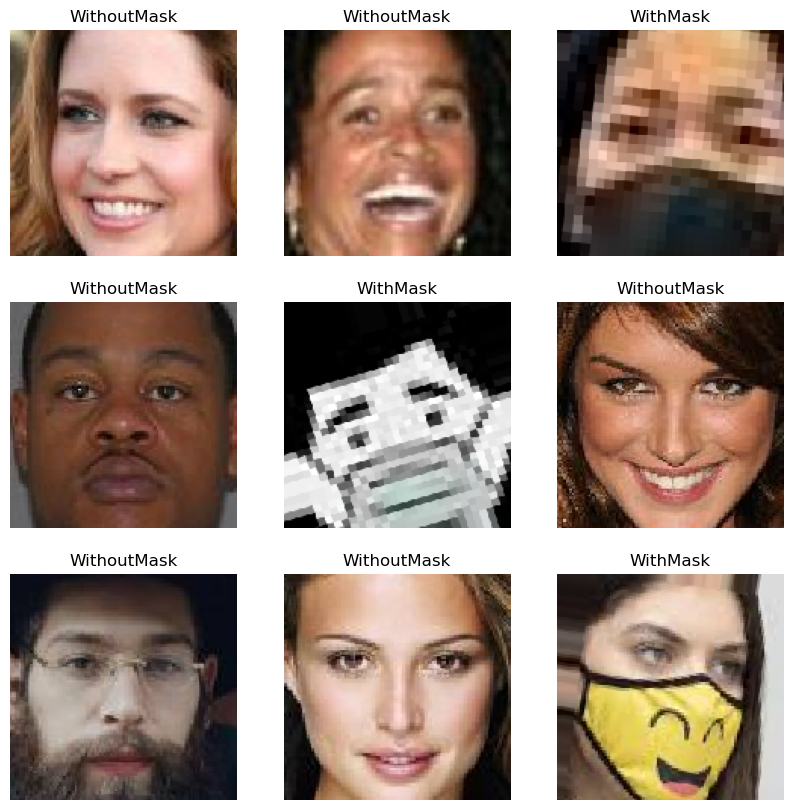

In [127]:
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    break
plt.show()

In [128]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [129]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 17, 17, 128)      

In [130]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.optimizers.Adam(),
    metrics=['accuracy'],
)

In [131]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=8,
    epochs=100,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100
8/8 [==============================] - 2s 103ms/step - loss: 0.6149 - accuracy: 0.6797 - val_loss: 0.3874 - val_accuracy: 0.8875
Epoch 2/100
8/8 [==============================] - 0s 55ms/step - loss: 0.2925 - accuracy: 0.9141 - val_loss: 0.3724 - val_accuracy: 0.8625
Epoch 3/100
8/8 [==============================] - 0s 52ms/step - loss: 0.3060 - accuracy: 0.8828 - val_loss: 0.2733 - val_accuracy: 0.9000
Epoch 4/100
8/8 [==============================] - 0s 49ms/step - loss: 0.2130 - accuracy: 0.9297 - val_loss: 0.2343 - val_accuracy: 0.9062
Epoch 5/100
8/8 [==============================] - 0s 48ms/step - loss: 0.2087 - accuracy: 0.9258 - val_loss: 0.1946 - val_accuracy: 0.9375
Epoch 6/100
8/8 [==============================] - 0s 51ms/step - loss: 0.2735 - accuracy: 0.9023 - val_loss: 0.2189 - val_accuracy: 0.9375
Epoch 7/100
8/8 [==============================] - 0s 51ms/step - loss: 0.2306 - accuracy: 0.9219 - val_loss: 0.2457 - val_accuracy: 0.9062
Epoch 8/100
8/8 [==

In [132]:
model.evaluate(validation_generator)

5/5 [==============================] - 0s 23ms/step - loss: 0.1006 - accuracy: 0.9875


[0.10064655542373657, 0.987500011920929]

In [133]:
from sklearn.metrics import classification_report

y_pred = model.predict(validation_generator)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(classification_report(validation_generator.classes, y_pred))

5/5 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        80
           1       0.98      1.00      0.99        80

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



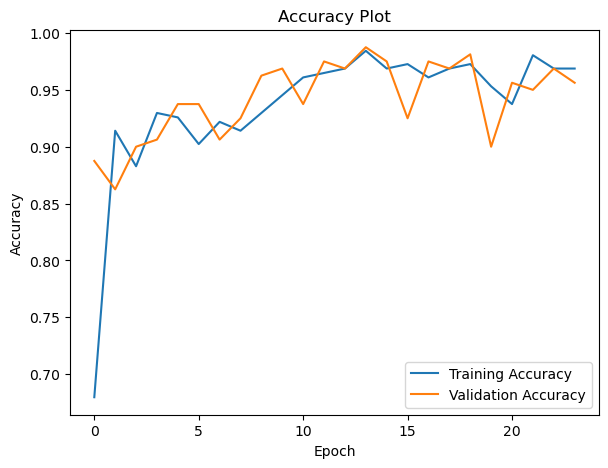

In [134]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

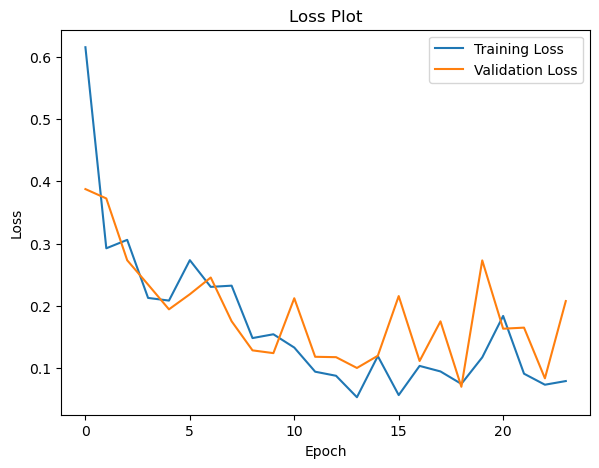

In [135]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()